In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup as bs
from tqdm import tqdm

In [2]:
def url_parser(sDate, eDate, row=10):
    ### API 연결 및 데이터 파싱
    key="VFYXI%2F3A5kIk7QVsO1epAlZSb6ZtCO9N5VC%2FMF3pW6oZ7%2BsFrvH1Y9y0UfmVzTnA0k2FasoNM6t6JsY7%2BEwNEw%3D%3D"
    # 기본 url+사용자 key
    url='http://api.visitkorea.or.kr/openapi/service/rest/KorService/searchFestival?serviceKey='+key
    url=url+'&MobileOS=ETC&MobileApp=AppTest&arrange=A&listYN=Y' #기본 필수 옵션
    url=url+"&numOfRows="+str(row)      # 한페이지 출력 데이터 개수
    url=url+"&eventStartDate="+str(sDate)  #조회 시작일
    url=url+"&eventEndDate="+str(eDate)    #조회 종료일
    #print(url)
    xml_soup=requests.get(url)
    if xml_soup.status_code !=200:
        print("API를 연결하지 못 했습니다.")
        exit()
        
    soup=bs(xml_soup.content, 'html.parser') #xml_soup.text 변경 가능
    return soup



In [3]:
def tour_info(sDate, eDate, soup):
    ### 파싱한 데이터에서 원하는 데이터 추출 및 DataFrame로 변경
    row=soup.find('totalcount').text
    soup=url_parser(sDate, eDate, row)

    items=soup.find_all('item')
    df_list=[]

    for item in items:
        staD=item.find('eventstartdate').text
        endD=item.find('eventenddate').get_text()
        titD=item.find('title').get_text()
        try:
            addD=item.find('addr1').get_text()
        except:
            addD="온라인 개최"
        try:
            telD=item.find('tel').get_text()
        except:
            telD="-"
        try:
            lngD=item.find('mapx').get_text()
            latD=item.find('mapy').get_text()
        except:
            lngD=0
            latD=0




        df_list.append({'시작 날짜': staD, '종료 날짜':endD, '축제명':titD, '주소':addD,
                       '전화번호':telD, '위도':latD, '경도': lngD} )
    df1=pd.DataFrame(df_list)

    return df1



In [ ]:
#if __name__== "__main__":
sDate=input('조회 시작일:(예:20200101)')
eDate=input('조회 종료일:(예:20201231)')


soup=url_parser(sDate, eDate)
df1=tour_info(sDate, eDate, soup)
#df1.to_csv('c:/pydata/tour_'+str(sDate)+"_"+str(eDate)+'.csv', index=False)

display(df1)

### 축제 데이터 분석
- 1. 2020년~2021년 축제 건수 비교(시작일 기준)
- 2. 축제유형(집합/비대면 축제)
- 3. 지역별 축제 현황

In [13]:
cnt19=0;cnt20=0;cnt21=0


for cntDate in  df1['시작 날짜']:
    if cntDate[0:4] == "2019":
        cnt19+=1
    if cntDate[0:4] == "2020":
        cnt20+=1
    if cntDate[0:4] == "2021":
        cnt21+=1

print(cnt19, cnt20, cnt21)
        


8 362 357


In [14]:
df1['시작년']=df1['시작 날짜'].str[:4]
df2=df1.groupby(['시작년'])['축제명'].count()

C:\Users\user1\miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user1\miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51089 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user1\miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user1\miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\user1\miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51089 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\user1\miniconda3\envs\multi\lib\site-packages\matplotlib\bac

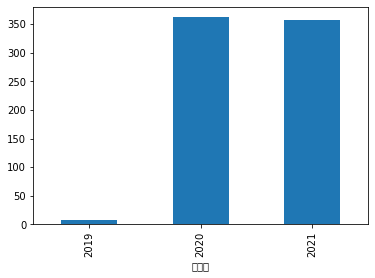

In [15]:
import matplotlib.pyplot as plt

df2.plot.bar()
plt.show()

In [16]:
from datetime import datetime

df1['시작 날짜']=pd.to_datetime(df1['시작 날짜'])
df1['종료 날짜']=pd.to_datetime(df1['종료 날짜'])
df1.dtypes

시작 날짜    datetime64[ns]
종료 날짜    datetime64[ns]
축제명              object
주소               object
전화번호             object
위도               object
경도               object
시작년              object
dtype: object

<AxesSubplot:ylabel='시작년'>

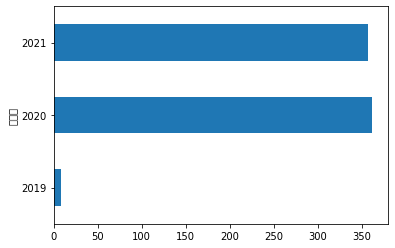

In [17]:
df1['시작년']=df1['시작 날짜'].dt.year
df1['시작월']=df1['시작 날짜'].dt.month
df2=df1.groupby(['시작년'])['축제명'].count()
df2.plot.barh()

- 축제 시작 년/시작월을 기본으로 groupby 
- concat()으로 추가하기

In [18]:
df2=df1.groupby(['시작년', '시작월'])['축제명'].count() #축ㅈ제 시작년/시작월 기준 건수 확인
df2=df2.reset_index() #'시작년' ,'시작월'을 데이터로 사용하기위해 index 재설정
#print(df2[df2['시작년']==2021].set_index('시작월'))

df3 = df2[df2['시작년']==2021].set_index('시작월') #index 시작월로 재설정
df4 = df2[df2['시작년']==2020].set_index('시작월')

df3 = df3.rename(columns = {df3.columns[1]: '2021Y'})        #각각의 재설정 데이터의 열 이름 변경
df4 = df4.rename(columns = {df4.columns[1]: '2020Y'})

df2 = pd.concat([df3, df4], axis = 1) #df3를 기준으로 열 추가 => 결과를 df2 저장
del df3, df4 #df3,4, 삭제

print(df2)


      시작년  2021Y     시작년  2020Y
시작월                            
1    2021     43  2020.0    3.0
2    2021     17     NaN    NaN
3    2021     18     NaN    NaN
4    2021     54     NaN    NaN
5    2021     64  2020.0    1.0
6    2021     44  2020.0    2.0
7    2021     38  2020.0    7.0
8    2021     16  2020.0   50.0
9    2021     21  2020.0   78.0
10   2021     34  2020.0  121.0
11   2021      6  2020.0   70.0
12   2021      2  2020.0   30.0


In [19]:
df3=df1.groupby(['시작년','시작월'])['축제명'].count()
df3=df3.reset_index()
df3=pd.concat([df3[df3['시작년']==2021].set_index('시작월'),
               df3[df3['시작년']==2020].set_index('시작월')], axis=1)
df3.drop('시작년', axis=1, inplace=True)
print(df3)

     축제명    축제명
시작월            
1     43    3.0
2     17    NaN
3     18    NaN
4     54    NaN
5     64    1.0
6     44    2.0
7     38    7.0
8     16   50.0
9     21   78.0
10    34  121.0
11     6   70.0
12     2   30.0


In [20]:
#df2.drop('시작년', axis=1, inplace=True)
df2=df2.fillna(0)


C:\Users\user1\miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user1\miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51089 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user1\miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user1\miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user1\miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\user1\miniconda3\envs\multi\lib\site-packages\matplotlib\b

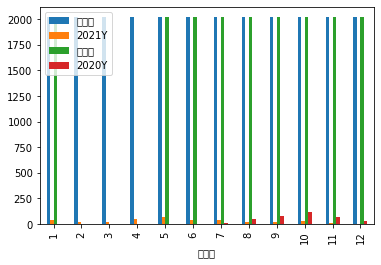

In [21]:
df2.plot.bar()
plt.show()

In [22]:
print(df1[(df1['주소']=='온라인개최')&(df1['시작년']==2020)]['주소'].count())
print(df1[(df1['주소']!='온라인개최')&(df1['시작년']==2020)]['주소'].count())

110
252


In [23]:
print(df1[(df1['주소']=='온라인개최')&(df1['시작년']==2021)]['주소'].count())
print(df1[(df1['주소']!='온라인개최')&(df1['시작년']==2021)]['주소'].count())

34
323


In [24]:
pList=[]
pList.append([df1[(df1['주소']=='온라인개최')&(df1['시작년']==2020)]['주소'].count(),
             df1[(df1['주소']!='온라인개최')&(df1['시작년']==2020)]['주소'].count()])
pList.append([df1[(df1['주소']=='온라인개최')&(df1['시작년']==2021)]['주소'].count(),
             df1[(df1['주소']!='온라인개최')&(df1['시작년']==2021)]['주소'].count()])
pList

[[110, 252], [34, 323]]

In [25]:
df2=pd.DataFrame(pList, columns=['온라인', '오프라인'], index=['2020년','2021년'])
df2

,온라인,오프라인
2020년,110,252
2021년,34,323


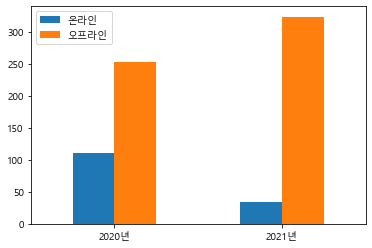

In [26]:
import matplotlib.font_manager as fm
font_name=fm.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family=font_name)


df2.plot.bar(rot=0)

plt.show()

In [27]:
#!pip install seaborn

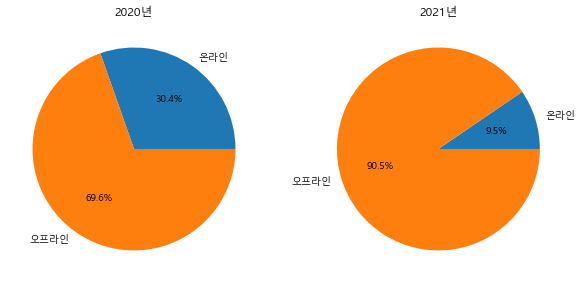

In [28]:
import seaborn as sns
fig=plt.figure(figsize=(10, 5))
#ax1=fig.add_subplot(1,2,1)
#ax2=fig.add_subplot(1,2,2)

plt.subplot(1,2,1)
x=list(df2.iloc[0])
xlab=df2.columns
plt.pie(x, labels=xlab, autopct='%.1f%%')
plt.title('2020년')

plt.subplot(1,2,2)
x=list(df2.iloc[1])
xlab=df2.columns
plt.pie(x, labels=xlab, autopct='%.1f%%')
plt.title('2021년')

plt.show()

In [29]:
[df2.iloc[0,0], df2.iloc[0,1]]

[110, 252]

In [30]:
print(list(df2.loc['2020년']))
print(list(df2.iloc[0]))

[110, 252]
[110, 252]


### 지역별 축제 현황
- 주소를 " " 기준으로 나누어 첫번쨰 값 선택
- 해당 값을 이용해서 '지역' 열 생성 및 데이터 추가
- 지역별 축제 현황(현황 테이블화, 시각화-막대그래프,원그래프, 히트맨 그래프)

,시작 날짜,종료 날짜,축제명,주소,전화번호,위도,경도,시작년,시작월
0,2021-03-06,2021-10-30,가무악극으로 만나는 토요 상설공연,충청남도 부여군 규암면 백제문로 388,041-832-5765,36.3048428766,126.8997016069,2021,3
1,2021-03-20,2021-06-30,가산수피아 '봄의 정원',경상북도 칠곡군 가산면 학하들안2길 105,054-971-9861,36.0861545517,128.4850691574,2021,3
2,2021-01-16,2021-12-31,가족끼리 빙어체험 2021,경기도 양평군 단월면 곱다니길 55-2 수미마을 방문객센터,031-775-5205,37.5145504080,127.6574135888,2021,1
3,2021-03-01,2021-06-06,가족끼리딸기 캠피닉,경기도 양평군 단월면 곱다니길 55-2,031-775-5205,37.5144948588,127.6573663730,2021,3
4,2021-02-25,2021-02-28,가족오페라 <마술피리> 2021,대구광역시 북구 호암로 15,053-666-6170,35.8835072863,128.5922570230,2021,2
...,...,...,...,...,...,...,...,...,...
722,2021-10-13,2021-10-17,[문화관광축제] 추억의 충장축제 2021,광주광역시 동구 서남로 1,062-608-2421~4,35.1454973445,126.9231294053,2021,10
723,2021-05-23,2021-11-30,[문화관광축제] 춘천마임축제,강원도 춘천시 전역,033-242-0585,37.8766011603,127.7178558012,2021,5
724,2021-08-12,2021-08-21,[문화관광축제] 통영한산대첩축제,경상남도 통영시 통영해안로 328,055-644-5222,34.8438295639,128.4241721001,2021,8
725,2021-06-11,2021-06-13,[문화관광축제] 한산모시문화제,충청남도 서천군 한산면 충절로 1089,041-950-4256,36.0799251950,126.7987054614,2021,6


In [124]:
locLst=[]

for i in df1['주소']:
    a=i.split(" ")[0] 
    locLst.append(a)


df1['지역']=locLst
pd.DataFrame(df1.groupby(['시작년','지역'])['축제명'].count())





    

축제명
시작년  지역          
2019 강원도        2
     경기도        2
     서울특별시      1
     온라인개최      1
     제주특별자치도    2
2020 강원도       20
     경기도       43
     경북         4
     경상남도      16
     경상북도      11
     광주광역시      3
     대구         2
     대구광역시     14
     대전광역시      4
     백종원        1
     부산         1
     부산광역시     14
     비대면개최      1
     서울         1
     서울시        1
     서울특별시     54
     세종         1
     온라인        1
     온라인개최    110
     울산         1
     울산광역시      6
     인천광역시      5
     전라남도      10
     전라북도      11
     제주특별자치도    9
     충청남도      11
     충청북도       7
2021 강원         2
     강원도       29
     경기도       49
     경남         1
     경상남도      15
     경상북도      10
     광주광역시     10
     대구광역시     19
     부산         1
     부산광역시     22
     비대면개최      1
     서울         1
     서울시        1
     서울특별시     78
     세종특별자치시    1
     온라인개최     34
     울산광역시      4
     인천광역시      5
     전남         1
     전라남도       4
     전라북도      24
     제주         1
     제주특별자치도   21
     충북         1
     충청남도      18
     충청북도       4

In [253]:
#!pip install folium

### 지도에 축제 위치 출력하기
- folium 모듈

In [254]:
import folium

In [259]:
umap=folium.Map(location=[37.43316742171981, 127.15627172697948], zoom_start=15) #기본 맵 생성, zoom_start=15,사이즈 확대/축소)
### 생성된 맵에 Marker(위치기호)를 추가한다
folium.Marker(location=[37.43316742171981, 127.15627172697948], icon=folium.Icon(color="red"),
             popup='집').add_to(umap)
umap.save('c:/pydata/집.html')

In [261]:
df2=df1[(df1['위도']!=0)&(df1['시작년']==2021)]

umap=folium.Map(location=[37.43316742171981, 127.15627172697948], zoom_start=15)

for inx in df2.index:
    folium.Marker(location=[df2.loc[inx,'위도'],df2.loc[inx,'경도']], icon=folium.Icon(color="red"),
             popup=df2.loc[inx,'축제명']).add_to(umap)
    
umap.save('c:/pydata/2021_축제_정보.html')

In [271]:
umap=folium.Map(location=[37.43316742171981, 127.15627172697948], zoom_start=11)

### 지도에 동그라미 표시
folium.CircleMarker([37.43316742171981, 127.15627172697948], color="red", fill_color="red", radius=10, popup="집").add_to(umap)

umap